# CH02.1. **다층 퍼셉트론(Multi Layer Perceptron)**

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 1000

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import torch

In [3]:
#(2) Set options
np.random.seed(seed=SEED_NUM)
torch.manual_seed(seed=SEED_NUM)
torch.cuda.manual_seed_all(seed=SEED_NUM)

In [4]:
#(3) Define user-defined function
def describe_df(df:pd.DataFrame) :
    return pd.DataFrame(data={
        'dtype'          : df.dtypes,
        'null_count'     : df.isnull().sum(),
        'non_null_count' : (df.shape[0] - df.isnull().sum()),
        'unique_count'   : df.nunique()
    })

def compute_rmse(model:torch.nn.Module, loader:torch.utils.data.DataLoader) :
    with torch.no_grad() : 
        square_sum = 0
        num_instances = 0
        model.eval()
        for data in loader :
            inputs, targets = data
            outputs = model(inputs)
            square_sum += torch.sum(input=(outputs - targets)**2).item()
            num_instances += len(targets)

    model.train()
    return np.sqrt(square_sum/num_instances)

In [5]:
#(4) Define class
class TensorDataset(torch.utils.data.Dataset) :
    def __init__(self, df, pred_label_nm):
        self.feature = torch.Tensor(data=df.drop(labels=pred_label_nm, axis=1).values)
        self.label = torch.Tensor(data=df.loc[:, pred_label_nm].values)
        self.len = self.label.shape[0]
    def __getitem__(self, index) :
        return self.feature[index], self.label[index]
    def __len__(self) :
        return self.len

class MyRegressionModel(torch.nn.Module) :
    def __init__(self):
        super().__init__()
        dims = [13, 1024, 512, 256, 128, 64, 32, 16, 8]
        self.layers = torch.nn.ModuleList()
        for i in range(len(dims)-1) :
            block = torch.nn.ModuleList([
                torch.nn.Linear(in_features=dims[i], out_features=dims[i+1]),
                torch.nn.BatchNorm1d(num_features=dims[i+1]),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.2)
            ])
            self.layers.append(block)
        self.layers.append(torch.nn.Linear(dims[-1], 1))
    
    def forward(self, x) :
        for block in self.layers[:-1] :
            for layer in block :
                x = layer(x)
        x = self.layers[-1](x)
        x = x.squeeze(-1)
        return x

<b></b>

## 01. **데이터셋 호출 및 EDA**

#### 01.1. **데이터셋 불러오기**

In [6]:
boston_raw = pd.read_csv(filepath_or_buffer='../../data/reg.csv', index_col=[0])

#### 01.2. **EDA**

In [7]:
#(1)
boston_raw.head(n=10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333
5,0.038651,0.019568,0.139449,0.719852,0.560581,0.610531,0.578661,0.387926,0.133629,0.072967,0.514078,0.986385,0.127396,0.526667
6,0.033301,0.136658,0.336651,0.274996,0.472140,0.331155,0.643546,0.661869,0.270651,0.239929,0.475964,0.993516,0.300521,0.397778
7,0.026858,0.151993,0.300627,0.115449,0.463345,0.532618,0.938389,0.465781,0.139893,0.238901,0.243669,0.991425,0.431171,0.491111
8,0.021739,0.132378,0.259349,0.488716,0.389581,0.411536,0.984672,0.526151,0.201324,0.236329,0.306712,0.965204,0.767177,0.255556
9,0.014588,0.144471,0.331099,0.759479,0.696532,0.334544,0.834204,0.611416,0.174935,0.237351,0.437982,0.967070,0.445798,0.308889


In [8]:
#(2)
describe_df(df=boston_raw)

,dtype,null_count,non_null_count,unique_count
x1,float64,0,506,506
x2,float64,0,506,506
x3,float64,0,506,506
x4,float64,0,506,506
x5,float64,0,506,506
x6,float64,0,506,506
x7,float64,0,506,506
x8,float64,0,506,506
x9,float64,0,506,506
x10,float64,0,506,506


In [9]:
#(2)
boston_raw.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).transpose()

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
x1,506.0,0.070683,0.094121,0.0,0.009277,0.021546,0.029774,0.040230,0.070544,0.152625,0.474918,1.0
x2,506.0,0.135605,0.226440,0.0,0.005060,0.013862,0.020509,0.030190,0.150837,0.433315,0.889557,1.0
x3,506.0,0.424234,0.232037,0.0,0.064563,0.143858,0.223651,0.363078,0.654769,0.704949,0.939676,1.0
x4,506.0,0.505672,0.182282,0.0,0.102131,0.262666,0.385348,0.500202,0.624019,0.760341,0.916720,1.0
x5,506.0,0.483965,0.167281,0.0,0.109317,0.277177,0.373733,0.484539,0.594011,0.698900,0.860339,1.0
x6,506.0,0.475751,0.150927,0.0,0.108966,0.287963,0.378476,0.470054,0.578155,0.671596,0.836432,1.0
x7,506.0,0.662663,0.282371,0.0,0.039376,0.234653,0.426510,0.751473,0.914585,0.963567,0.987286,1.0
x8,506.0,0.317333,0.181286,0.0,0.030038,0.105378,0.173847,0.286750,0.431015,0.571865,0.791924,1.0
x9,506.0,0.359104,0.310675,0.0,0.027075,0.109420,0.150533,0.204117,0.802832,0.880734,0.936835,1.0
x10,506.0,0.422760,0.319778,0.0,0.005177,0.090098,0.177237,0.275718,0.908668,0.912402,0.916972,1.0


<b></b>

## 02. **데이터셋 전처리**

#### 02.1. **학습 및 검증 데이터셋 분리**

In [10]:
boston_train, boston_test = sklearn.model_selection.train_test_split(boston_raw, train_size=0.7, random_state=SEED_NUM)

#### 02.2. **텐서 변환**

In [11]:
#(1)
boston_train = TensorDataset(df=boston_train, pred_label_nm='Price')

#(2)
boston_test = TensorDataset(df=boston_test, pred_label_nm='Price')

#### 02.3. **데이터로더 변환**

In [12]:
#(1)
boston_train_loader = torch.utils.data.DataLoader(dataset=boston_train, batch_size=BATCH_SIZE, shuffle=True)

#(2)
boston_test_loader = torch.utils.data.DataLoader(dataset=boston_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 03. **모델 구축 및 학습**

#### 03.1. **모델 등 객체 정의**

In [13]:
#(1)
model = MyRegressionModel()

#(2)
display(model)

MyRegressionModel(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=13, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): ModuleList(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (2): ModuleList(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (3): ModuleList(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=

In [14]:
#(2)
criterion = torch.nn.MSELoss()

#(3)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=1e-7)

#### 03.2. **모델 학습**

In [15]:
#(1)
# loss_threshold = 1
best_loss = float('inf')
loss_hist = []
batch_cnt = len(boston_train_loader)

#(2)
for epoch in tqdm.tqdm(iterable=range(EPOCH_NUM)) : 
    running_loss = 0.0
    model.train()
    for data in boston_train_loader :
        inputs, targets = data 
        optimizer.zero_grad() 
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss_avg = running_loss / batch_cnt
    loss_hist.append(running_loss_avg)
    # if running_loss_avg < best_loss :
    #     best_loss = running_loss_avg
    #     torch.save(
    #         obj={
    #             'epoch'     : epoch,
    #             'loss'      : loss_hist,
    #             'model'     : model.state_dict(),
    #             'optimizer' : optimizer.state_dict()
    #         }, 
    #         f='../../model/reg4-1.pt'
    #     )

100%|██████████| 1000/1000 [01:40<00:00,  9.94it/s]


<b></b>

## 04. **모델 평가**

#### 04.1. **손실(loss) 확인**

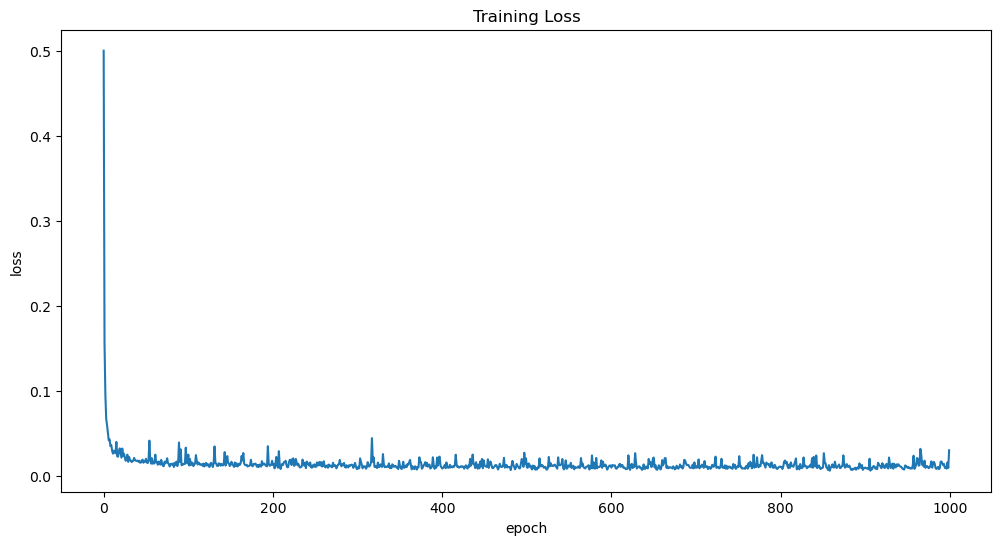

In [16]:
plt.figure(figsize=(12, 6))
plt.title(label='Training Loss')
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_hist)
plt.show()

#### 04.2. **성능 평가** (by RMSE)

In [17]:
#(1)
train_rmse = compute_rmse(model=model, loader=boston_train_loader) # 학습 데이터의 RMSE
test_rmse = compute_rmse(model=model, loader=boston_test_loader) # 시험 데이터의 RMSE

#(2)
print(f'>> Train RMSE: {train_rmse}')
print(f'>> Test RMSE : {test_rmse}')

>> Train RMSE: 0.0797475006527273
>> Test RMSE : 0.117934977266705
